In [289]:
import os
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import sklearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.compose import ColumnTransformer
import joblib
import h2o

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats
import matplotlib.style as style

#from utils.customs import *

# Data Loading

In [2]:
df_train_all = pd.read_csv('./input/train.csv')
df_test_all = pd.read_csv('./input/test.csv')

In [3]:
# df_train_all would be used for following analysis. Keep a copy in original_df_train_all
original_df_train_all = df_train_all.copy()

In [4]:
df_train_all.columns

Index(['POSTED_BY', 'UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 'BHK_OR_RK',
       'SQUARE_FT', 'READY_TO_MOVE', 'RESALE', 'ADDRESS', 'LONGITUDE',
       'LATITUDE', 'TARGET(PRICE_IN_LACS)'],
      dtype='object')

In [5]:
df_train_all.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5


# Raw Data Feature Description

Column and it's Description

* POSTED_BY - Category marking who has listed the property
* UNDER_CONSTRUCTION - Under Construction or Not 
* RERA - Rera approved or Not
* BHK_NO - Number of Rooms
* BHKORRK - Type of property
* SQUARE_FT - Total area of the house in square feet
* READYTOMOVE - Category marking Ready to move or Not
* RESALE - Category marking Resale or not
* ADDRESS - Address of the property
* LONGITUDE - Longitude of the property
* LATITUDE - Latitude of the property
* TARGET - Price in lacs

# EDA

<a id="QuickProfiling0"></a>
## Quick Profiling

In [5]:
ProfileReport(df_train_all)

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<a id ='QuickProfiling'></a>
Observations:
- No missing data, 374 duplications. Action: [Remove Duplications](#RemoveDups) 
- Address has hagh cardinality. Action: [Feature Engineering, extract city from Address. Tier the cities](#NewFeature)
- High correlation between UNDER_CONSTRUCTION, READY_TO_MOVE are perfectly opposite. Action: consider [remove one of them](#Multicolinearity) 
- High correlation between BHK_NO., SQUARE_FT. Action: further assessment in [Feature Assessment(Multicolinearity)](#Multicolinearity)
- Relatively high correlation amoung UNDER_CONSTRUCTION, RERA, RESALE. Action: further assessment in [Feature Assessment(Multicolinearity)](#Multicolinearity)
- SQUARE_FT distribution is higly skewed(skewness = 166.6). Action: consider log transformation. See [Transform Exsisting Feature](#FeatureTransform)
- TARGET(PRICE_IN_LACS) distribution looks skewed (skewness = 17.58). Action consider log transaformation. See [Transform Exsisting Feature](#FeatureTransform)

<a id = 'FixFindings'></a>
## Fix Findings

Based on the discussion in [Quick Profiling](#QuickProfiling), following fixes have been applied to df_train_all data frame for further analysis purpose.
    
The data transformations would be implemented in a formal transformer pipeline at model building phase. See details in Section [Preprocessor](#Preprocessor).    

<a id = 'RemoveDups'></a>
### Remove Duplicates

As discussed in [Quick Profiling](#QuickProfiling), remove duplicate records in training data.

In [409]:
df_traian_all.drop_duplicates(inplace = True)

In [25]:
df_train_all.shape

(29050, 16)

<a id="NewFeature"></a>
### Create a New Feature

As discussed in [Quick Profiling](#QuickProfiling), feature ADDRESS has high cardinality issue. will be converted
- use lowercase words to name created / transformed features
- ADDRESS -> city -> city tier
- map all cities to tier1, tier2, tier3 based on __[https://en.wikipedia.org/wiki/Classification_of_Indian_cities](https://en.wikipedia.org/wiki/Classification_of_Indian_cities)__

In [26]:
df_train_all['city'] = df_train_all['ADDRESS'].str.split(',').apply(lambda x: x[-1])

In [27]:
tier1 = {'Ahmedabad', 'Bangalore', 'Chennai', 'Delhi', 'Hyderabad', 'Kolkata', 'Mumbai', 'Pune', 'Maharashtra'}
tier2 = {'Agra', 'Ajmer', 'Aligarh', 'Amravati', 'Amritsar', 'Asansol', 'Aurangabad', 'Bareilly', 
                  'Belgaum', 'Bhavnagar', 'Bhiwandi', 'Bhopal', 'Bhubaneswar', 'Bikaner', 'Bilaspur', 'Bokaro Steel City', 
                  'Chandigarh', 'Coimbatore', 'Cuttack', 'Dehradun', 'Dhanbad', 'Bhilai', 'Durgapur', 'Dindigul', 'Erode', 
                  'Faridabad', 'Firozabad', 'Ghaziabad', 'Gorakhpur', 'Gulbarga', 'Guntur', 'Gwalior', 'Gurgaon', 'Guwahati', 
                  'Hamirpur', 'Hubli–Dharwad', 'Indore', 'Jabalpur', 'Jaipur', 'Jalandhar', 'Jammu', 'Jamnagar', 'Jamshedpur', 
                  'Jhansi', 'Jodhpur', 'Kakinada', 'Kannur', 'Kanpur', 'Karnal', 'Kochi', 'Kolhapur', 'Kollam', 'Kozhikode', 
                  'Kurnool', 'Ludhiana', 'Lucknow', 'Madurai', 'Malappuram', 'Mathura', 'Mangalore', 'Meerut', 'Moradabad', 
                  'Mysore', 'Nagpur', 'Nanded', 'Nashik', 'Nellore', 'Noida', 'Patna', 'Pondicherry', 'Purulia', 'Prayagraj', 
                  'Raipur', 'Rajkot', 'Rajahmundry', 'Ranchi', 'Rourkela', 'Ratlam', 'Salem', 'Sangli', 'Shimla', 'Siliguri', 
                  'Solapur', 'Srinagar', 'Surat', 'Thanjavur', 'Thiruvananthapuram', 'Thrissur', 'Tiruchirappalli', 'Tirunelveli', 
                  'Tiruvannamalai', 'Ujjain', 'Bijapur', 'Vadodara', 'Varanasi', 'Vasai-Virar City', 'Vijayawada', 'Visakhapatnam', 
                  'Vellore', 'Warangal'}
def city2tier(city):
    if city in tier1:
        return 'tier1'
    elif city in tier2:
        return 'tier2'
    else:
        return 'tier3'    

In [28]:
df_train_all['city_tier'] = df_train_all['city'].apply(city2tier)

In [29]:
df_train_all.head(3)

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),city,city_tier,log_square_ft,log_price_in_lacs
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0,Bangalore,tier1,7.170301,4.007333
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0,Mysore,tier2,7.150701,3.931826
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0,Bangalore,tier1,6.838576,3.761200


<a id = "FeatureTransform"></a>
### Transform Existing Features

As discussed in [Quick Profiling](#QuickProfiling), the distributions of 'SQUARE_FT' and 'TARGET(PRICE_IN_LACS)' are highly skewed. Actually if use them without any transformation, the predicted House Price could have negative cases. 

Apply log transformation.

In [30]:
df_train_all['log_square_ft'] = np.log(df_train_all['SQUARE_FT'])
df_train_all['log_price_in_lacs'] = np.log(df_train_all['TARGET(PRICE_IN_LACS)'])

In [31]:
def compare_before_after_log(df, feature1, feature2):
    style.use('fivethirtyeight')

    ## Creating a customized chart. and giving in figsize and everything. 
    fig = plt.figure(constrained_layout=True, figsize=(14,6))
    ## creating a grid of 3 cols and 3 rows. 
    grid = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
    #gs = fig3.add_gridspec(3, 3)

    ## before log. 
    ax1 = fig.add_subplot(grid[0, :1])
    ## Set the title. 
    ax1.set_title('before log')
    sns.distplot(df.loc[:,feature1], norm_hist=True, ax = ax1)

    # after log. 
    ax2 = fig.add_subplot(grid[0, 1:])
    ## Set the title. 
    ax2.set_title('after log')
    sns.distplot(df.loc[:,feature2], norm_hist=True, ax = ax2)

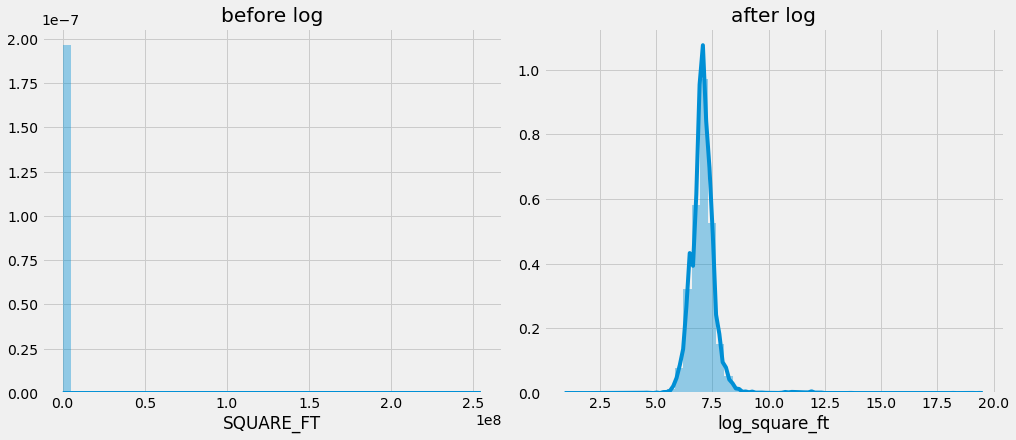

In [32]:
compare_before_after_log(df_train_all, 'SQUARE_FT', 'log_square_ft')

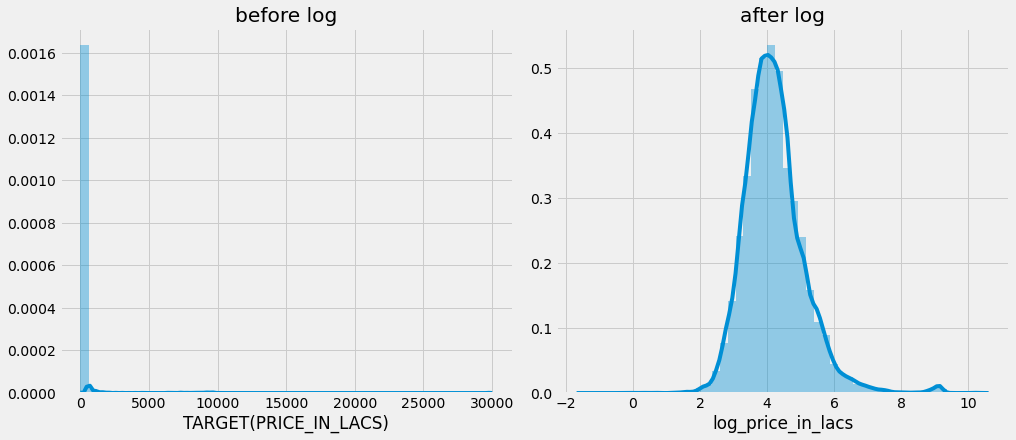

In [33]:
compare_before_after_log(df_train_all, 'TARGET(PRICE_IN_LACS)', 'log_price_in_lacs')

Observation: the skewness has been alleviated

BHK_NO. has slightly significant skewness (skewness = 2)
- Add a logged BHK_NO. for analysis convenience
- This logged BHK_NO. is less likely to use in model

In [43]:
df_train_all['log_bhk_no'] = np.log(df_train_all['BHK_NO.'])

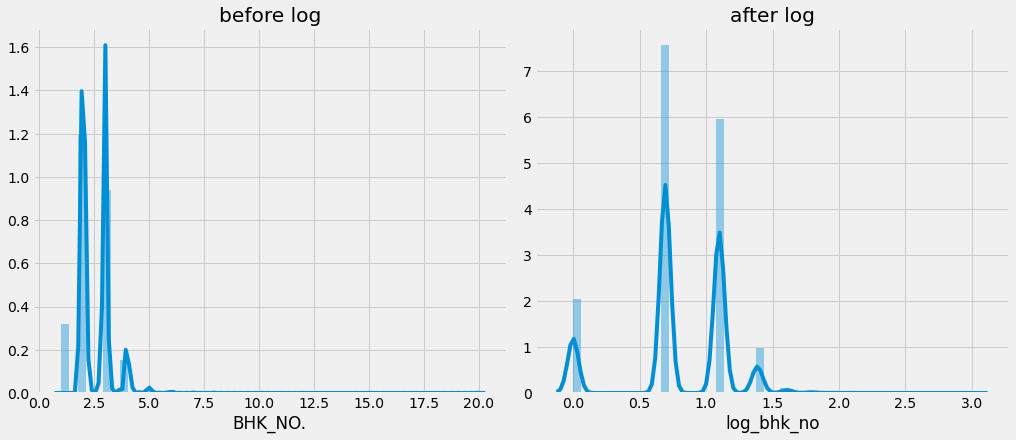

In [45]:
compare_before_after_log(df_train_all, 'BHK_NO.', 'log_bhk_no')

<a id="Interaction"></a>
## Feature Interaction Analysis

In this section, we evaluate the relationship between features and target variable. The [Quick Profiling](#QuickProfiling0) only provided the interaction analysis for numerical features. In this section, a comprehansive interaction analysis would be performed on both numerical and categorical features. The log transformed variables from Section [Transform Existing Features](#FeatureTransform) would be assessed especially.

In [445]:
# numerical lm scatter ploting
def plot_numerical(df, features, log_target = True, hue = None):
    if not features: return 
    target = 'log_price_in_lacs' if log_target else 'TARGET(PRICE_IN_LACS)'    
    if type(features) == str:
        sns.lmplot(x=feature, y= target, data = df, scatter_kws = {"s": 5}, line_kws = {"linewidth": 1}, hue = hue)
        plt.show()
    elif type(features) == list:
        n = len(features)
        total_rows = (n + 1) // 2
        fig = plt.figure(constrained_layout=True, figsize=(14, 6 * total_rows))
        grid = gridspec.GridSpec(ncols=2, nrows=total_rows, figure=fig)
        
        idx = 0
        for r in range(0, total_rows):
            ax1 = fig.add_subplot(grid[r, 0])
            sns.regplot(x = features[idx], y = target, data = df, scatter_kws = {"s": 5}, line_kws = {"linewidth": 1}, ax = ax1)
            idx += 1
            
            if idx == n: break
            ax2 = fig.add_subplot(grid[r, 1])
            sns.regplot(x = features[idx], y = target, data = df, scatter_kws = {"s": 5}, line_kws = {"linewidth": 1}, ax = ax2)
            idx += 1
        plt.show()
        
    else:
        return

# categorical features plotting
    
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct
def plot_categorical(df, feature, figsize=None, log_target = True):
    target = 'log_price_in_lacs' if log_target else 'TARGET(PRICE_IN_LACS)'
    df = df.groupby([feature])[target].describe()[['mean', '50%', 'min', 'count']]

    labels = df.index.values
    x = np.arange(len(labels))
    width = 0.9
    fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(16, 8))
    
    # plot bars for min, median and mean house price
    rects1 = ax1.bar(x-width/2, df['50%'], width/3, label='median')
    rects2 = ax1.bar(x-width/6, df['mean'], width/3, label='mean')
    rects3 = ax1.bar(x+width/6, df['min'], width/3, label='min')

    ax1.set_ylabel(target, fontsize=12)
    ax1.set_title(feature + ' (values)', fontsize = 15)
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels, rotation=0)
    ax1.legend()

    ax2.set_title(feature + ' (population)', fontsize = 15)
    ax2.pie(df['count'], labels = df.index, autopct=make_autopct(df['count']))
    ax2.legend()
    plt.show()

In [436]:
df_train_all.columns

Index(['POSTED_BY', 'UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 'BHK_OR_RK',
       'SQUARE_FT', 'READY_TO_MOVE', 'RESALE', 'ADDRESS', 'LONGITUDE',
       'LATITUDE', 'TARGET(PRICE_IN_LACS)', 'city', 'city_tier',
       'log_square_ft', 'log_price_in_lacs', 'bhk_no_lt_8', 'log_bhk_no'],
      dtype='object')

In [437]:
numerical_features = ['log_square_ft', 'BHK_NO.', 'log_bhk_no', 'LONGITUDE', 'LATITUDE']
onehot_categorical_features = ['POSTED_BY', 'city_tier'] # multi classes
label_categorical_features = ['UNDER_CONSTRUCTION', 'READY_TO_MOVE', 'RERA', 'RESALE', 'BHK_OR_RK'] # binary classes
#other_categorical_features = ['city']

### Numerical Features

To better demonstrate the numerical relationship between target and numerical features, log target is used.

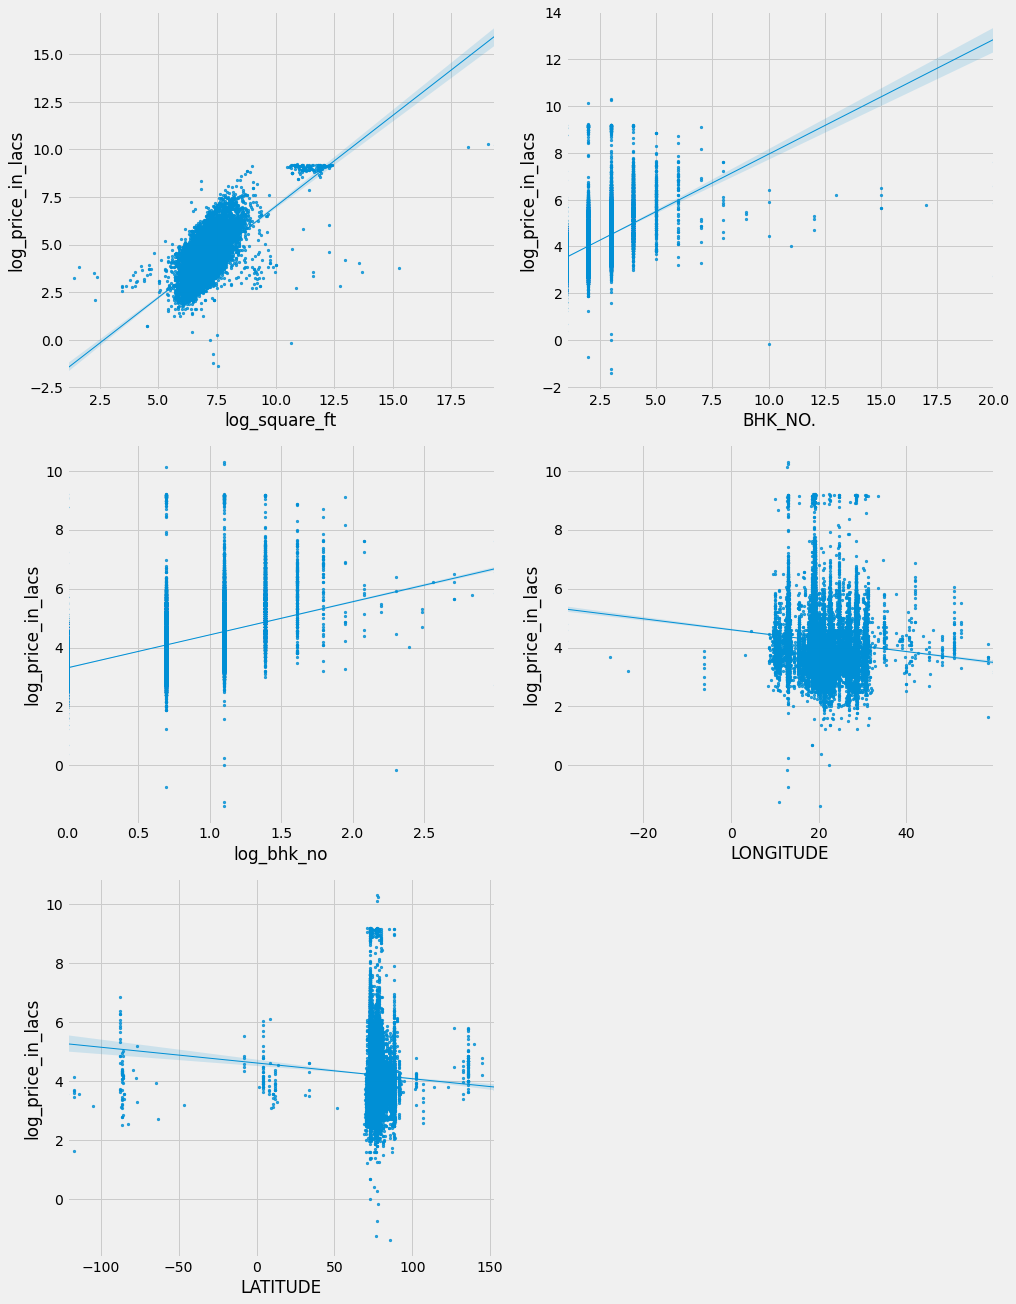

In [446]:
plot_numerical(df_train_all, numerical_features, log_target = True)

Observations: 
- log_square_ft has positive contribution to target house price
- BHK_NO has 'linear-like' positive contribution to the target house price when BHK-NO. < 8. Further assess below
- log_bhk_no won't be used in inital model, since the BHK_NO already has little skewness and clear 'linear-like' house price contribution. Use the original BHK_NO. instead.
- The impacts from LONGITUDE, LATITUDE are not as sigificant. They might be used as tree features with city/city tier features

In [22]:
# BHK_NO
pd.value_counts(df_train_all['BHK_NO.'])

2     13324
3     10546
1      3574
4      1723
5       190
6        52
7        11
8        10
20        4
10        4
15        4
9         3
12        3
17        1
11        1
13        1
Name: BHK_NO., dtype: int64

In [39]:
df_train_all['BHK_NO.'].quantile(0.95)

4.0

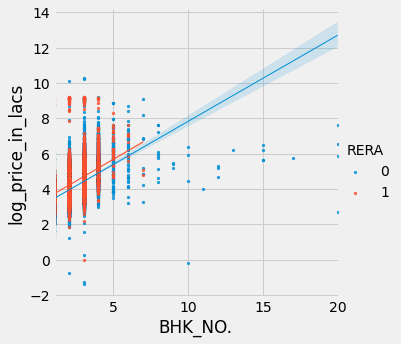

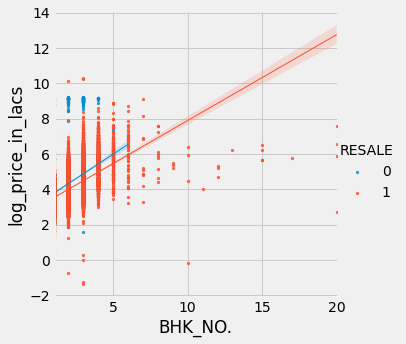

In [413]:
for hue in ['RERA', 'RESALE']:
    plot_numerical(df_train_all, 'BHK_NO.', log_target = True, hue = hue)

Further Observations for BHK_NO.:
- Only 21 out of 29050 records have BHK_NO. > 10
- The records with BHK_NO. > 10 don't have RERA approved but ready for RESALE. Partially segmented by RERA and RESALE.

Action: add a spare feature 'bhk_no_lt_8', in case model performance need lift. It won't be used in first try. The tree model might already identify this split.


In [41]:
df_train_all['bhk_no_lt_8'] = df_train_all['BHK_NO.'].apply(lambda x: 1 if x < 8 else 0) 

### Categorical Features

In interaction analysis for categorical features, the original TARGET(PRICE_IN_LACS) is used.

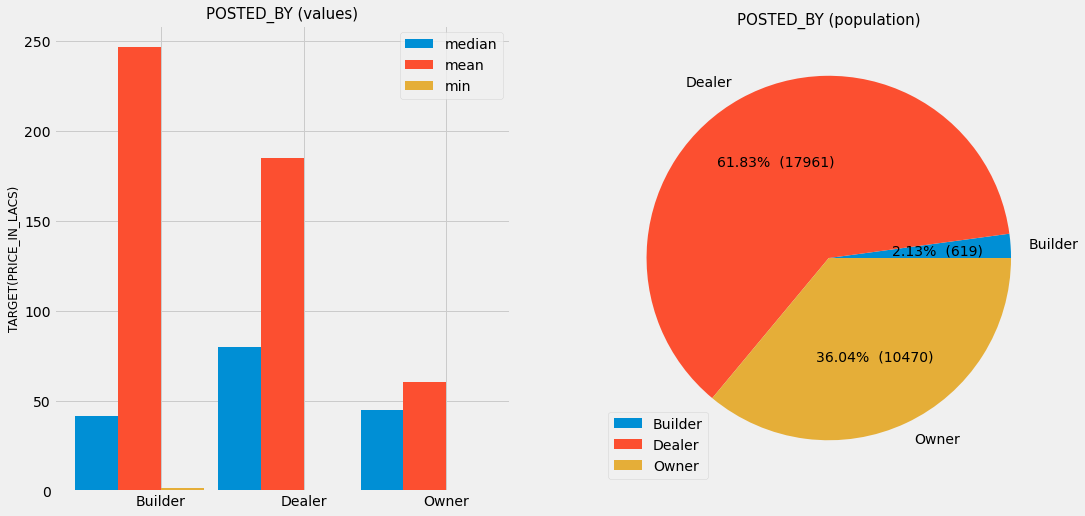

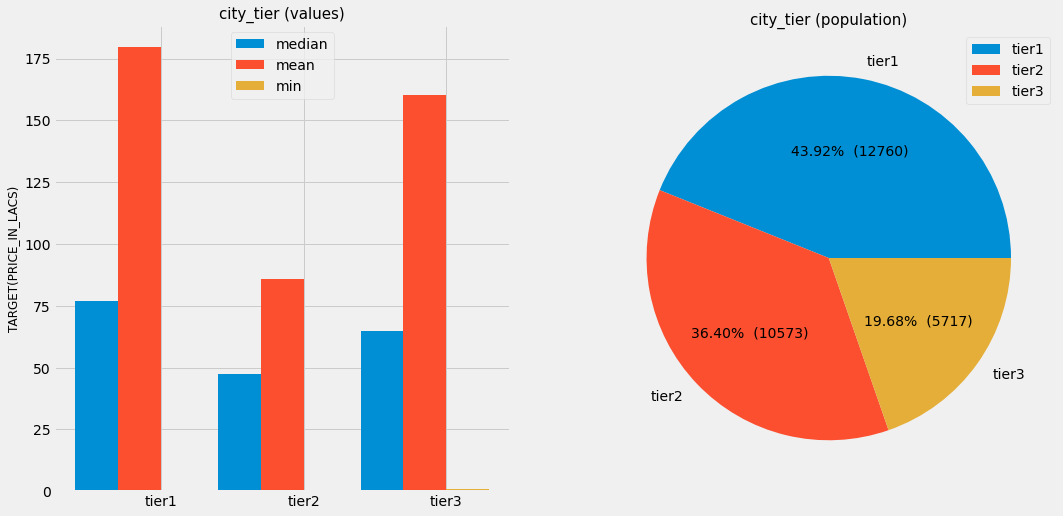

In [84]:
for feature in onehot_categorical_features:
    plot_categorical(df_train_all, feature, log_target = False)

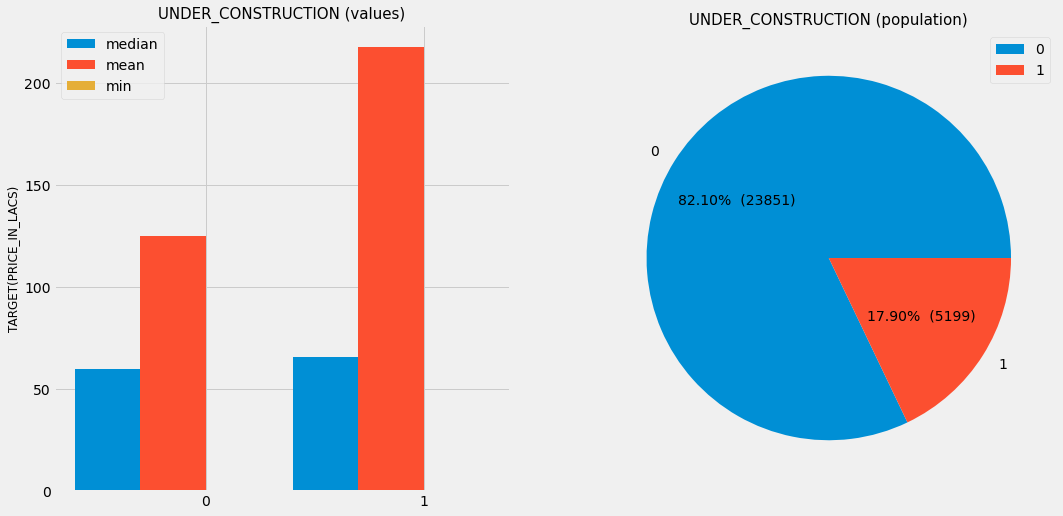

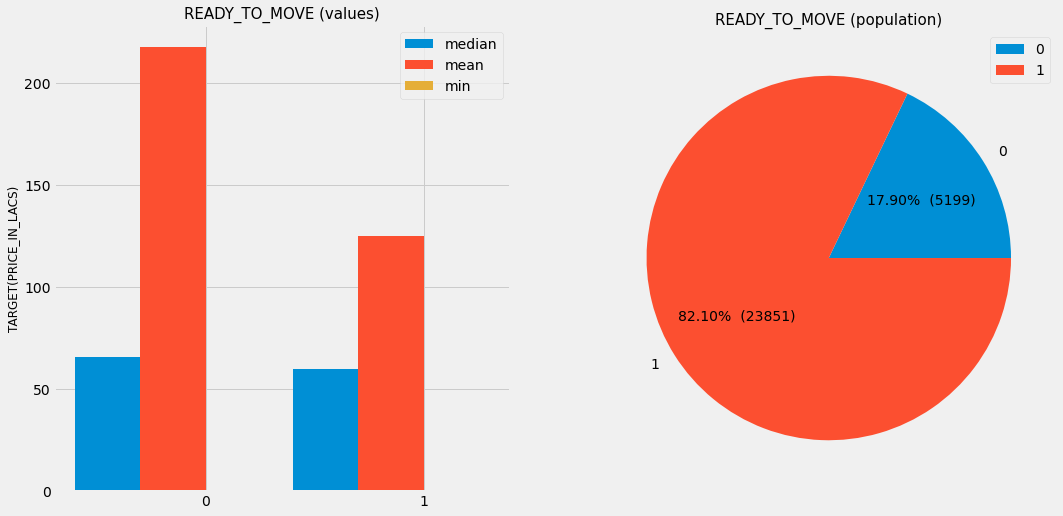

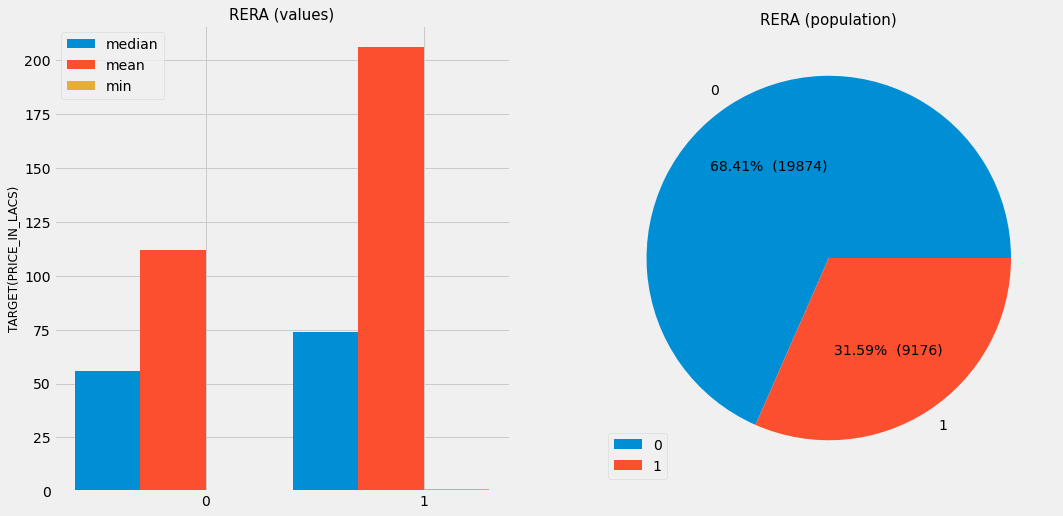

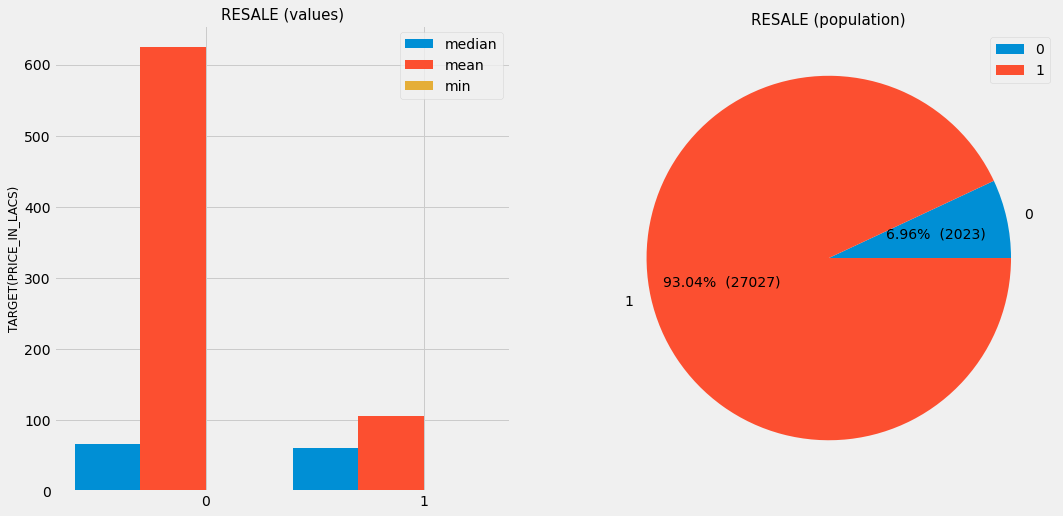

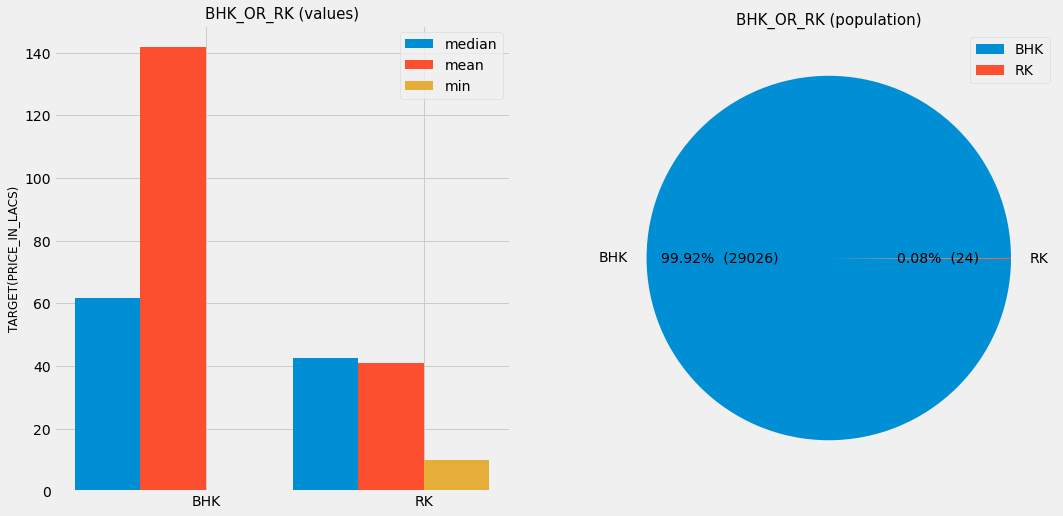

In [85]:
for feature in label_categorical_features:
    plot_categorical(df_train_all, feature, log_target = False)

Observations:
- POSTED_BY: 'Builder' has generally high while 'Owner' has the least
- city_tier: 'tier1' have highest house prices
- UNDER_CONSTRUCTION: positive contribution to house price
- RERA: positive contribution to house price
- BHK_OR_RK: 'BHK' has higher house price
- RESALE: negative impact to house price

Note: 
- READY_TO_MOVE won't be used. It is exactly opposite to UNDER_CONSTRUCTION
- Besides the plotting, formal correlation after categorical feature labeling or f_regression / mutual information analysis could be also performed quantitatively to investigate the feature impacts upon the target variable. sklearn.feature_selection has plenty of support in these analysis. The plotting has demonstrated the relationship rather clearly. We are not dipping too much into the quantitative evaluation methods here.



<a id = "Multicolinearity"></a>
## Feature Assessment (Multicolinearity)

Based on the feature correlation analysis in [Quick Profiling](#QuickProfiling0) and interaction analysis in [Feature Interaction Analysis](#Interaction), the candidate features to predict India house prices include:
- numerical: log_square_ft, BHK_NO., LONGITUDE, LATITUDE
- onehot catigorical: POSTED_BY, city_tier
- label catigorical: UNDER_CONSTRUCTION, RERA, RESALE, BHK_OR_RK

In [486]:
numerical_features_candi = ['log_square_ft', 'BHK_NO.', 'LONGITUDE', 'LATITUDE']
onehot_categorical_features_candi = ['POSTED_BY', 'city_tier']
label_categorical_features_candi = ['UNDER_CONSTRUCTION', 'RERA', 'RESALE', 'BHK_OR_RK']

In [488]:
# label encode the categoricals for final assessment
df_assess = df_train_all.copy()[numerical_features_candi + onehot_categorical_features_candi + label_categorical_features_candi]
for feature in onehot_categorical_features_candi + label_categorical_features_candi:
    le = LabelEncoder()
    df_assess[feature] = le.fit_transform(df_assess[feature])

Assess the Variance Inflation Factor(VIF) for the features

In [489]:
vif = pd.DataFrame()
vif["variables"] = list(df_assess.columns)
vif["VIF"] = [variance_inflation_factor(df_assess[vif['variables']].values, i) for i in range(len(vif["variables"]))]
print(vif)

            variables        VIF
0       log_square_ft  85.258652
1             BHK_NO.  11.830974
2           LONGITUDE  15.313752
3            LATITUDE  44.005817
4           POSTED_BY   9.080156
5           city_tier   2.464432
6  UNDER_CONSTRUCTION   1.516207
7                RERA   1.805231
8              RESALE  17.033335
9           BHK_OR_RK   1.006159


In [490]:
vif = pd.DataFrame()
vif["variables"] = list(df_assess.drop(columns = [ 'LATITUDE', 'LONGITUDE', 'log_square_ft', 'RESALE']).columns)
vif["VIF"] = [variance_inflation_factor(df_assess[vif['variables']].values, i) for i in range(len(vif["variables"]))]
print(vif)

            variables       VIF
0             BHK_NO.  4.667980
1           POSTED_BY  4.403160
2           city_tier  1.933021
3  UNDER_CONSTRUCTION  1.391365
4                RERA  1.660283
5           BHK_OR_RK  1.004500


In [126]:
sum(df_assess['UNDER_CONSTRUCTION'] + df_assess['RESALE'])

32226

In [128]:
df_assess.shape

(29050, 10)

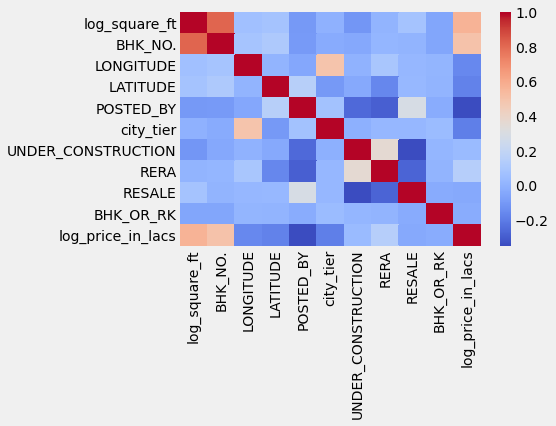

In [495]:
# glance the spearson rho after labelling once more
df_assess_w_target = df_assess.copy()
df_assess_w_target['log_price_in_lacs'] = df_train_all['log_price_in_lacs']
sns.heatmap(df_assess_w_target.corr('spearman'), annot=False, cmap='coolwarm')


Observation:
- VIF assessment further indicates that there remains high multicolinearity in
    - log_square_ft and BHK_NO.
    - UNDER_CONSTRUCTION, RESALE

which is consistent with the observations by correlation analysis in [Quick Profiling](#QuickProfiling)

Solution Options:
- for Simple Linear Regression: the high colinearity varibles need removing. For feature selection, we could use:
    - univariate feature selection: ie. f_regression, mutal_information, all based on correlation between features and target
    - sequential feature selection: forward or backward
    - sklearn.feature_selection has plenty of support for these feature selection methiods
- for Linear Regression with Lasso Regularization: regularization is able to keep one of the colinearity features and force others' coeficients to zero
- for Tree based method (Random Forest Tree/ Gradient Boosting Tre): A base unit tree chooses only one of the colinearity features. The accuracy of the tree based models won't be impacted significantly if features with colinearity are used. However, the importances of the features might be confusing in the end.

Our Choice: 
- READY_TO_MOVE has been removed from model features since it is exactly opposite to UNDER_CONSTRUCTION
- For log_square_ft vs BHK_NO, UNDER_CONSTRUCTION vs RESALE, I am prone to keep them all, since:
    - They are not perfectly correlated to one another
    - They all have explanationary power for target prediction. See [Feature Interaction Analysis](#Interaction)
    - Tree models or Lasso in linear regression could handle the feature pickings for the feature candidates with multicollinearity, We are using tree models and regularization to "select" the features
    
The features to use remain the same:

- numerical: log_square_ft, BHK_NO., LONGITUDE, LATITUDE
- onehot catigorical: POSTED_BY, city_tier
- label catigorical: UNDER_CONSTRUCTION, RERA, RESALE, BHK_OR_RK

## Data Assessment (Outlier)

In [248]:
# IQR Assessment
mul = 1.5
outlier_percentage = {}
for feature in ['log_square_ft', 'SQUARE_FT', 'BHK_NO.', 'TARGET(PRICE_IN_LACS)', 'log_price_in_lacs']:
    tempData = df_train_all.sort_values(by=feature)[feature]
    Q1, Q3 = tempData.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    Lower_range = Q1 - (mul * IQR)
    Upper_range = Q3 + (mul * IQR)
    outlier_percentage[feature] = round((((tempData<(Q1 - mul * IQR)) | (tempData>(Q3 + mul * IQR))).sum()/tempData.shape[0])*100,2)
outlier_percentage

{'log_square_ft': 3.52,
 'SQUARE_FT': 5.55,
 'BHK_NO.': 0.97,
 'TARGET(PRICE_IN_LACS)': 10.48,
 'log_price_in_lacs': 3.29}

Observation:
After log, there are only 3.29 % log_price_in_lacs out of IQR range. Keep them for initial modelings

# Model Building

In [448]:
#Preprocessing related Imports
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, LabelBinarizer, OneHotEncoder, FunctionTransformer
from sklearn.base import BaseEstimator,TransformerMixin

#Regressors
from sklearn.model_selection import cross_val_score, GridSearchCV,StratifiedShuffleSplit,RandomizedSearchCV
from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor# ,AdaBoostRegressor, GradientBoostingRegressor,HistGradientBoostingRegressor
#from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

#Evaluation
from sklearn.metrics import fbeta_score, make_scorer, mean_absolute_error, r2_score

In [451]:
# create working folders
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
create_dir('./ckpt')
create_dir('./ckpt/model_selection')
create_dir('./ckpt/model_selection/ridge')
create_dir('./ckpt/model_selection/lasso')
create_dir('./ckpt/model_selection/rf')
create_dir('./ckpt/model_selection/xgb')
create_dir('./ckpt/final_pipeline')

<a id = "Preprocessor"></a>
## Preprocessor

Convert Original Raw Data to Regressor Inputs following the Feature Engineering Logics in Section [Fix Findings](#FixFindings)

In [293]:
# Preprocessor Pipeline Definition
# Numerical Features
skewed_num_attrib = ['SQUARE_FT']
other_num_attribs=['BHK_NO.', 'LONGITUDE','LATITUDE']
# Categorical Features
label_cat_attribs=[ 'UNDER_CONSTRUCTION', 'RERA', 'RESALE'] # 3?
onehot_cat_attribs = ['POSTED_BY', 'BHK_OR_RK'] # 5
city_attrib = ['ADDRESS'] # 3
bhk_no_attrib = ['BHK_NO.']

column_names = skewed_num_attrib + other_num_attribs + label_cat_attribs + onehot_cat_attribs + city_attrib # + ['bnk_lt_8']
column_names_encoded = skewed_num_attrib + other_num_attribs + label_cat_attribs + [ 'POSTED_BY_dealer', 'POSTED_BY_owner',  'BHK_OR_RK_rk', 'ADDRESS_tier2', 'ADDRESS_tier3'] # + ['bnk_lt_8']
# Help Functions

tier1 = {'Ahmedabad', 'Bangalore', 'Chennai', 'Delhi', 'Hyderabad', 'Kolkata', 'Mumbai', 'Pune', 'Maharashtra'}
tier2 = {'Agra', 'Ajmer', 'Aligarh', 'Amravati', 'Amritsar', 'Asansol', 'Aurangabad', 'Bareilly', 
                  'Belgaum', 'Bhavnagar', 'Bhiwandi', 'Bhopal', 'Bhubaneswar', 'Bikaner', 'Bilaspur', 'Bokaro Steel City', 
                  'Chandigarh', 'Coimbatore', 'Cuttack', 'Dehradun', 'Dhanbad', 'Bhilai', 'Durgapur', 'Dindigul', 'Erode', 
                  'Faridabad', 'Firozabad', 'Ghaziabad', 'Gorakhpur', 'Gulbarga', 'Guntur', 'Gwalior', 'Gurgaon', 'Guwahati', 
                  'Hamirpur', 'Hubli–Dharwad', 'Indore', 'Jabalpur', 'Jaipur', 'Jalandhar', 'Jammu', 'Jamnagar', 'Jamshedpur', 
                  'Jhansi', 'Jodhpur', 'Kakinada', 'Kannur', 'Kanpur', 'Karnal', 'Kochi', 'Kolhapur', 'Kollam', 'Kozhikode', 
                  'Kurnool', 'Ludhiana', 'Lucknow', 'Madurai', 'Malappuram', 'Mathura', 'Mangalore', 'Meerut', 'Moradabad', 
                  'Mysore', 'Nagpur', 'Nanded', 'Nashik', 'Nellore', 'Noida', 'Patna', 'Pondicherry', 'Purulia', 'Prayagraj', 
                  'Raipur', 'Rajkot', 'Rajahmundry', 'Ranchi', 'Rourkela', 'Ratlam', 'Salem', 'Sangli', 'Shimla', 'Siliguri', 
                  'Solapur', 'Srinagar', 'Surat', 'Thanjavur', 'Thiruvananthapuram', 'Thrissur', 'Tiruchirappalli', 'Tirunelveli', 
                  'Tiruvannamalai', 'Ujjain', 'Bijapur', 'Vadodara', 'Varanasi', 'Vasai-Virar City', 'Vijayawada', 'Visakhapatnam', 
                  'Vellore', 'Warangal'}
def city2tier(city):
    if city in tier1:
        return 'tier1'
    elif city in tier2:
        return 'tier2'
    else:
        return 'tier3'    
    
def addr2tier(addr_arr):
    a = map(lambda row: [city2tier(row[0].split(',')[-1])], addr_arr)
    return list(a)

def bnk_lt_8(bnk_arr):
    a = map(lambda row: [1 if row[0] < 8 else 0], bnk_arr)
    return list(a)
                         
# Transformers
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

#log_transformer = 
#addr2tier_transformer = 

class CustomLabelBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self, sparse_output=False):
        self.sparse_output = sparse_output
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        enc = LabelBinarizer(sparse_output=self.sparse_output)
        return enc.fit_transform(X)

# Subpipelines
# --
skewed_num_subline = Pipeline([
    ('selector',DataFrameSelector(skewed_num_attrib)),
    ('log', FunctionTransformer(np.log)),
    ('std',StandardScaler())
])
other_num_subline = Pipeline([
    ('selector',DataFrameSelector(other_num_attribs)),
    ('std',StandardScaler())
])
#--

label_cat_subline =Pipeline([
    ('selector',DataFrameSelector(label_cat_attribs)),
    ('Binarizer',CustomLabelBinarizer(sparse_output=True))
])


onehot_cat_subline = Pipeline([
    ('selector',DataFrameSelector(onehot_cat_attribs)),
    ('Binarizer',OneHotEncoder(drop = 'first'))
])

city_cat_subline = Pipeline([
    ('selector',DataFrameSelector(city_attrib)),
    ('addr2tier', FunctionTransformer(addr2tier)),
    ('Binarizer',OneHotEncoder(drop = 'first'))
])

bkn_lt_8_cat_subline = Pipeline([
    ('selector',DataFrameSelector(bhk_no_attrib)),
    ('addr2tier', FunctionTransformer(bnk_lt_8)),
    ('Binarizer',OneHotEncoder(drop = 'first'))
])


# Proprocessing Pipeline

preprocessingPipeline=FeatureUnion(transformer_list=[
    ('skewed_num_subline', skewed_num_subline),
    ('other_num_subline', other_num_subline),
    ('label_cat_subline', label_cat_subline), # 2
    ('onehot_cat_subline', onehot_cat_subline), #5
    ('city_cat_subline', city_cat_subline) #3
#    ('bkn_lt_8_cat_subline', bkn_lt_8_cat_subline)
])

Assess against df_train_all

In [294]:
original_df_train_all.drop_duplicates(inplace = True)

In [295]:
# Preprocessor Pipeline Fitting
preprocessingPipeline.fit_transform(original_df_train_all)

<29050x12 sparse matrix of type '<class 'numpy.float64'>'
	with 202347 stored elements in Compressed Sparse Row format>

In [296]:
processed = preprocessingPipeline.transform(original_df_train_all)

In [297]:
X_train_all = pd.DataFrame(processed.toarray(), columns = column_names_encoded)

Assessment

In [298]:
X_train_all

,SQUARE_FT,BHK_NO.,LONGITUDE,LATITUDE,UNDER_CONSTRUCTION,RERA,RESALE,POSTED_BY_dealer,POSTED_BY_owner,BHK_OR_RK_rk,ADDRESS_tier2,ADDRESS_tier3
0,0.144035,-0.443768,-1.339661,0.072712,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.110869,-0.443768,-1.451893,-0.017505,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
2,-0.417301,-0.443768,-1.370630,0.075951,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,-0.423184,-0.443768,1.189830,0.048727,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
4,-0.301916,-0.443768,0.213356,1.102952,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
29045,1.250284,0.691743,0.947463,0.114853,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
29046,-0.744204,-0.443768,3.014128,-15.422948,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
29047,-0.262352,-0.443768,0.913272,-0.094781,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
29048,-0.428364,-0.443768,-1.350920,0.321586,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [210]:
df_train_all

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),city,city_tier,log_square_ft,log_price_in_lacs,bhk_no_lt_8,log_bhk_no
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0,Bangalore,tier1,7.170301,4.007333,1,0.693147
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0,Mysore,tier2,7.150701,3.931826,1,0.693147
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0,Bangalore,tier1,6.838576,3.761200,1,0.693147
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5,Ghaziabad,tier2,6.835100,4.135167,1,0.693147
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5,Kolkata,tier1,6.906764,4.102643,1,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29446,Owner,0,0,3,BHK,2500.000000,1,1,"Shamshabad Road,Agra",27.140626,78.043277,45.0,Agra,tier2,7.824046,3.806662,1,1.098612
29447,Owner,0,0,2,BHK,769.230769,1,1,"E3-108, Lake View Recidency,,Vapi",39.945409,-86.150721,16.0,Vapi,tier3,6.645391,2.772589,1,0.693147
29448,Dealer,0,0,2,BHK,1022.641509,1,1,"Ajmer Road,Jaipur",26.928785,75.828002,27.1,Jaipur,tier2,6.930144,3.299534,1,0.693147
29449,Owner,0,0,2,BHK,927.079009,1,1,"Sholinganallur,Chennai",12.900150,80.227910,67.0,Chennai,tier1,6.832039,4.204693,1,0.693147


In [170]:
Y_train_all = np.log(original_df_train_all['TARGET(PRICE_IN_LACS)'])

Observation: 
- Categorical values are consistent
- Numerical values are consistent if the normalization (StandardScaler()) part is disabled

Preprocessor has been implemented correctly

## Model Selection

As discussed in [Feature/Data Selection](#Feature/Data-Selection), there are colinearity in the current feature set. Candidate Models include:
- Linear Regression with Regularization
- Bagging: Random Forest Regressor
- Boosting: XG Boosting Regressor

The numerical features have been normalized. The categorical features have been encoded to 1s. Regularization is good to apply.

Grid Search with Cross Validation is used for Model Selection.

Randomized Search was not used due to time cost.

### Evaluation Functions

In [174]:
# the training target is log house price, apply exponential calculation before compare
def neg_mean_absolute_exponential_error(y_true, y_pred):
    return -abs(np.exp(y_true) - np.exp(y_pred)).mean()

scoring = { 'neg_mean_absolute_error': 'neg_mean_absolute_error', 'neg_mean_abs_exp_err': make_scorer(neg_mean_absolute_exponential_error)}

In [457]:
key_metric = 'neg_mean_abs_exp_err'
minor_metric = 'neg_mean_absolute_error' if key_metric == 'neg_mean_abs_exp_err' else 'neg_mean_abs_exp_err'
mapp = {'neg_mean_absolute_error': 'mean_abs_err_of_log_house_price', 'neg_mean_abs_exp_err': 'mean_abs_err_of_house_price'}

### Ridge

In [461]:
param_grid = [
    { 'alpha': np.arange(0, 1, 0.02),  'max_iter':[100,200,400,500,800, 1000, 1300, 1500] ,'tol':[1e-4,1e-5]} 
  ]
ridge=Ridge()
grid_search = GridSearchCV(ridge, param_grid = param_grid, cv=5, scoring=scoring, refit = key_metric, verbose=10, n_jobs=-1)
grid_search.fit(X_train_all,Y_train_all)
ridge=grid_search.best_estimator_
idx = grid_search.cv_results_['rank_test_' + key_metric][0] - 1
print(mapp[key_metric] + ': %.3f' % -grid_search.best_score_)
print(mapp[minor_metric] +': %.3f' % -grid_search.cv_results_['mean_test_' + minor_metric][idx])
print('Config: %s' % grid_search.best_params_)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits
mean_abs_err_of_house_price: 166.916
mean_abs_err_of_log_house_price: 0.434
Config: {'alpha': 0.98, 'max_iter': 100, 'tol': 0.0001}


Summary:
- Best Config: {'alpha': 0.98, 'max_iter': 100}
- Prediction mean absolute error: 166.916

In [458]:
# save the model selection ridge pipeline
pipeline_ridge_ms = Pipeline(steps = [('preprocess', preprocessingPipeline), ('ridge', ridge)])
joblib.dump(pipeline_ridge_ms, './ckpt/model_selection/ridge/pipeline_ridge_ms.pkl')

['./ckpt/model_selection/ridge/pipeline_ridge_ms.pkl']

### Lasso

In [464]:
param_grid = [
    { 'alpha': np.arange(0, 1, 0.02), 'max_iter':[100,200,400,500,800, 1000, 1300, 1500]} # ,'tol':[1e-4,1e-5]
  ]
lasso=Lasso()
grid_search = GridSearchCV(lasso, param_grid = param_grid, cv=5, scoring=scoring, refit = key_metric, verbose=10, n_jobs=-1)
grid_search.fit(X_train_all,Y_train_all)
lasso=grid_search.best_estimator_
idx = grid_search.cv_results_['rank_test_' + key_metric][0] - 1
print(mapp[key_metric] + ': %.3f' % -grid_search.best_score_)
print(mapp[minor_metric] +': %.3f' % -grid_search.cv_results_['mean_test_' + minor_metric][idx])
print('Config: %s' % grid_search.best_params_)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
mean_abs_err_of_house_price: 93.742
mean_abs_err_of_log_house_price: 0.665
Config: {'alpha': 0.26, 'max_iter': 100}


Summary:
- Best Config: {'alpha': 0.26, 'max_iter': 100}
- Prediction mean absolute error: 93.742

In [465]:
# save the model selection lasso pipeline
pipeline_lasso_ms = Pipeline(steps = [('preprocess', preprocessingPipeline), ('lasso', lasso)])
joblib.dump(pipeline_lasso_ms, './ckpt/model_selection/lasso/pipeline_lasso_ms.pkl')

['./ckpt/model_selection/lasso/pipeline_lasso_ms.pkl']

### Random Forest Regressor

Due to time cost, GridSearch is performed on features seperately

In [238]:
# 1. Assess 'n_estimators'
param_grid1 = {'n_estimators':[10,20,30,40,50,60,70, 80, 90, 100]}
param_other = {'min_samples_split': 100, 'min_samples_leaf': 10, 'max_depth': 8, 'max_features': 'sqrt', 'oob_score': True, 'random_state': 42, 'n_jobs': -1}
forest_reg = RandomForestRegressor(**param_other)

grid_search = GridSearchCV(forest_reg, param_grid = param_grid1, cv=5,scoring = scoring, refit = key_metric, verbose=10, n_jobs=-1) 
grid_search.fit(X_train_all,Y_train_all)
forest_reg=grid_search.best_estimator_
idx = grid_search.cv_results_['rank_test_' + key_metric][0] - 1
print(mapp[key_metric] + ': %.3f' % -grid_search.best_score_)
print(mapp[minor_metric] +': %.3f' % -grid_search.cv_results_['mean_test_' + minor_metric][idx])
print('Config: %s' % grid_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
mean_abs_err_of_house_price: 67.783
mean_abs_err_of_log_house_price: 0.318
Config: {'n_estimators': 70}


In [239]:
# 2. Assess 'max_depth' and 'min_samples_split'
param_grid2 = {'max_depth':[3, 5, 7, 9, 11, 13, 14, 15], 'min_samples_split':[10, 20, 30, 40, 50,70,90,110,130,150,170,190]}
param_other = {'n_estimators': 70, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'oob_score': True, 'random_state': 42, 'n_jobs': -1}

forest_reg = RandomForestRegressor(**param_other)

grid_search = GridSearchCV(forest_reg, param_grid = param_grid2, cv=5,scoring = scoring, refit = key_metric, verbose=10, n_jobs=-1) 
grid_search.fit(X_train_all,Y_train_all)
forest_reg=grid_search.best_estimator_
idx = grid_search.cv_results_['rank_test_' + key_metric][0] - 1
print(mapp[key_metric] + ': %.3f' % -grid_search.best_score_)
print(mapp[minor_metric] +': %.3f' % -grid_search.cv_results_['mean_test_' + minor_metric][idx])
print('Config: %s' % grid_search.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
mean_abs_err_of_house_price: 58.662
mean_abs_err_of_log_house_price: 0.273
Config: {'max_depth': 14, 'min_samples_split': 10}


In [241]:
# 3. Assess 'min_samples_split' and 'min_samples_leaf'
param_grid3 = {'min_samples_split':[10, 20, 30, 40, 50, 60], 'min_samples_leaf':[10,20,30,40,50]}
param_other = {'n_estimators': 70, 'max_depth': 14, 'max_features': 'sqrt', 'oob_score': True, 'random_state': 42, 'n_jobs': -1}

forest_reg = RandomForestRegressor(**param_other)

grid_search = GridSearchCV(forest_reg, param_grid = param_grid3, cv=5,scoring = scoring, refit = key_metric, verbose=10, n_jobs=-1) 
grid_search.fit(X_train_all,Y_train_all)
forest_reg=grid_search.best_estimator_
idx = grid_search.cv_results_['rank_test_' + key_metric][0] - 1
print(mapp[key_metric] + ': %.3f' % -grid_search.best_score_)
print(mapp[minor_metric] +': %.3f' % -grid_search.cv_results_['mean_test_' + minor_metric][idx])
print('Config: %s' % grid_search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
mean_abs_err_of_house_price: 58.662
mean_abs_err_of_log_house_price: 0.273
Config: {'min_samples_leaf': 10, 'min_samples_split': 10}


In [242]:
# 4. Assess 'max_features'
param_grid4 = {'max_features':[3,5,7,9,11]}
param_other = {'n_estimators': 70, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 10, 'oob_score': True, 'random_state': 42, 'n_jobs': -1}

forest_reg = RandomForestRegressor(**param_other)

grid_search = GridSearchCV(forest_reg, param_grid = param_grid4, cv=5,scoring = scoring, refit = key_metric, verbose=10, n_jobs=-1) 
grid_search.fit(X_train_all,Y_train_all)
forest_reg=grid_search.best_estimator_
idx = grid_search.cv_results_['rank_test_' + key_metric][0] - 1
print(mapp[key_metric] + ': %.3f' % -grid_search.best_score_)
print(mapp[minor_metric] +': %.3f' % -grid_search.cv_results_['mean_test_' + minor_metric][idx])
print('Config: %s' % grid_search.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
mean_abs_err_of_house_price: 41.313
mean_abs_err_of_log_house_price: 0.251
Config: {'max_features': 11}


Summary:
- Best Config: {'n_estimators': 70, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 11}
- Prediction mean absolute error: 41.313
- Note: this is not a global GridSearch. A through global GridSearch or RandomizedSearch would achieve better performance


In [299]:
# save the model selection random forest regressor pipeline
pipeline_rf_ms = Pipeline(steps = [('preprocess', preprocessingPipeline), ('rf', forest_reg)])
joblib.dump(pipeline_rf_ms, './ckpt/model_selection/rf/pipeline_rf_ms.pkl')

['./ckpt/model_selection/rf/pipeline_rf_ms.pkl']

### XG Boosting Regressor

Similarly, due to time cost, assess hyperparameters one by one

In [316]:
key_metric = 'neg_mean_abs_exp_err'
minor_metric = 'neg_mean_absolute_error' if key_metric == 'neg_mean_abs_exp_err' else 'neg_mean_abs_exp_err'
mapp = {'neg_mean_absolute_error': 'mean_abs_err_of_log_house_price', 'neg_mean_abs_exp_err': 'mean_abs_err_of_house_price'}

In [255]:
# 1. Assess 'n_estimators'
param_grid1 = {'n_estimators':[30,40,50,60,70, 80, 90, 100, 120, 150, 170, 200, 250, 270, 300, 350, 400, 450, 500, 550, 600]}
param_other = {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'random_state': 1, 'objective':'reg:squarederror'}

xgb_reg = XGBRegressor(**param_other)

grid_search = GridSearchCV(xgb_reg, param_grid = param_grid1, cv=5,scoring = scoring, refit = key_metric, verbose=10, n_jobs=-1) 
grid_search.fit(X_train_all,Y_train_all)
xgb_reg=grid_search.best_estimator_
idx = grid_search.cv_results_['rank_test_' + key_metric][0] - 1
print(mapp[key_metric] + ': %.3f' % -grid_search.best_score_)
print(mapp[minor_metric] +': %.3f' % -grid_search.cv_results_['mean_test_' + minor_metric][idx])
print('Config: %s' % grid_search.best_params_)

Fitting 5 folds for each of 21 candidates, totalling 105 fits
mean_abs_err_of_house_price: 31.796
mean_abs_err_of_log_house_price: 0.221
Config: {'n_estimators': 600}


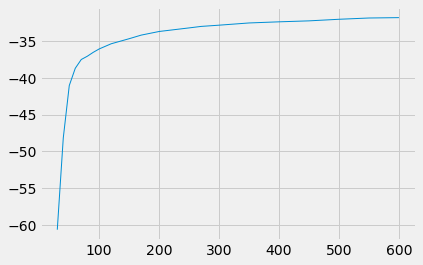

In [256]:
plt.plot(list(param_grid1.values())[0], grid_search.cv_results_['mean_test_neg_mean_abs_exp_err'], linewidth=1)

Although the score increases the number of trees grows up, the increment from 500 to 600 is actually rather flat. I would use 550 as the optimal n_estimates

In [259]:
# 2. Assess 'min_child_weight' and 'max_depth'
param_grid2 = {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'min_child_weight': [1, 2, 3, 4, 5, 6]}
param_other = {'n_estimators': 550, 'learning_rate': 0.1, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'random_state': 1, 'objective':'reg:squarederror'}

xgb_reg =  XGBRegressor(**param_other)

grid_search = GridSearchCV(xgb_reg, param_grid = param_grid2, cv=5,scoring = scoring, refit = key_metric, verbose=10, n_jobs=-1) 
grid_search.fit(X_train_all,Y_train_all)
xgb_reg=grid_search.best_estimator_
idx = grid_search.cv_results_['rank_test_' + key_metric][0] - 1
print(mapp[key_metric] + ': %.3f' % -grid_search.best_score_)
print(mapp[minor_metric] +': %.3f' % -grid_search.cv_results_['mean_test_' + minor_metric][idx])
print('Config: %s' % grid_search.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
mean_abs_err_of_house_price: 29.331
mean_abs_err_of_log_house_price: 0.209
Config: {'max_depth': 9, 'min_child_weight': 1}


In [261]:
# 3. Assess 'gamma', required minimum information gain
param_grid3 = {'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]}
param_other = {'n_estimators': 550, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0, 'reg_lambda': 1, 'random_state': 1, 'objective':'reg:squarederror'}

xgb_reg =  XGBRegressor(**param_other)

grid_search = GridSearchCV(xgb_reg, param_grid = param_grid3, cv=5,scoring = scoring, refit = key_metric, verbose=10, n_jobs=-1) 
grid_search.fit(X_train_all,Y_train_all)
xgb_reg=grid_search.best_estimator_
idx = grid_search.cv_results_['rank_test_' + key_metric][0] - 1
print(mapp[key_metric] + ': %.3f' % -grid_search.best_score_)
print(mapp[minor_metric] +': %.3f' % -grid_search.cv_results_['mean_test_' + minor_metric][idx])
print('Config: %s' % grid_search.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
mean_abs_err_of_house_price: 30.003
mean_abs_err_of_log_house_price: 0.210
Config: {'gamma': 0.1}


In [262]:
# 4. Assess 'subsample, colsample_bytree'
param_grid4 = {'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]}
param_other = {'n_estimators': 550, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'seed': 0,
                    'gamma': 0.1, 'reg_alpha': 0, 'reg_lambda': 1, 'random_state': 1, 'objective':'reg:squarederror'}

xgb_reg =  XGBRegressor(**param_other)

grid_search = GridSearchCV(xgb_reg, param_grid = param_grid4, cv=5,scoring = scoring, refit = key_metric, verbose=10, n_jobs=-1) 
grid_search.fit(X_train_all,Y_train_all)
xgb_reg=grid_search.best_estimator_
idx = grid_search.cv_results_['rank_test_' + key_metric][0] - 1
print(mapp[key_metric] + ': %.3f' % -grid_search.best_score_)
print(mapp[minor_metric] +': %.3f' % -grid_search.cv_results_['mean_test_' + minor_metric][idx])
print('Config: %s' % grid_search.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
mean_abs_err_of_house_price: 28.995
mean_abs_err_of_log_house_price: 0.210
Config: {'colsample_bytree': 0.9, 'subsample': 0.9}


In [263]:
# 5. Assess 'reg_alpha' and 'reg_lambda'
param_grid5 = {'reg_alpha': [0.05, 0.1, 1, 2, 3], 'reg_lambda': [0.05, 0.1, 1, 2, 3]}
param_other = {'n_estimators': 550, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.1, 'random_state': 1, 'objective':'reg:squarederror'}

xgb_reg =  XGBRegressor(**param_other)

grid_search = GridSearchCV(xgb_reg, param_grid = param_grid5, cv=5,scoring = scoring, refit = key_metric, verbose=10, n_jobs=-1) 
grid_search.fit(X_train_all,Y_train_all)
xgb_reg=grid_search.best_estimator_
idx = grid_search.cv_results_['rank_test_' + key_metric][0] - 1
print(mapp[key_metric] + ': %.3f' % -grid_search.best_score_)
print(mapp[minor_metric] +': %.3f' % -grid_search.cv_results_['mean_test_' + minor_metric][idx])
print('Config: %s' % grid_search.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
mean_abs_err_of_house_price: 28.844
mean_abs_err_of_log_house_price: 0.211
Config: {'reg_alpha': 0.1, 'reg_lambda': 1}


In [264]:
# 6. Assess 'learning_rate'
param_grid6 = {'learning_rate': [0.01, 0.05, 0.07, 0.1, 0.2]}
param_other = {'n_estimators': 550, 'max_depth': 9, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 1, 'random_state': 1, 'objective':'reg:squarederror'}

xgb_reg =  XGBRegressor(**param_other)

grid_search = GridSearchCV(xgb_reg, param_grid = param_grid6, cv=5,scoring = scoring, refit = key_metric, verbose=10, n_jobs=-1) 
grid_search.fit(X_train_all,Y_train_all)
xgb_reg=grid_search.best_estimator_
idx = grid_search.cv_results_['rank_test_' + key_metric][0] - 1
print(mapp[key_metric] + ': %.3f' % -grid_search.best_score_)
print(mapp[minor_metric] +': %.3f' % -grid_search.cv_results_['mean_test_' + minor_metric][idx])
print('Config: %s' % grid_search.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
mean_abs_err_of_house_price: 28.844
mean_abs_err_of_log_house_price: 0.214
Config: {'learning_rate': 0.1}


Summary:
- Best Config: {'n_estimators': 550, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'seed': 0,'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 1, 'random_state': 1, 'objective':'reg:squarederror'}
- Prediction mean absolute error: 28.844

In [300]:
# save the model selection xgb regressor pipeline
pipeline_xgb_ms = Pipeline(steps = [('preprocess', preprocessingPipeline), ('xgb', xgb_reg)])
joblib.dump(pipeline_xgb_ms, './ckpt/model_selection/xgb/pipeline_xgb_ms.pkl')

['./ckpt/model_selection/xgb/pipeline_xgb_ms.pkl']

### Model Selection Summary


five-fold cross validation mean absolute error:

| Ridge | Lasso | Random Forest Regression | XGB Regression |
| --- | --- | --- | --- |
| 166.916 | 93.742 | 41.313 | 28.844 |

- XGB Regressor has best performance 
- A pipline using XGB would be constructed in next session

Additional Plottings:

Text(0, 0.5, 'y_truth')

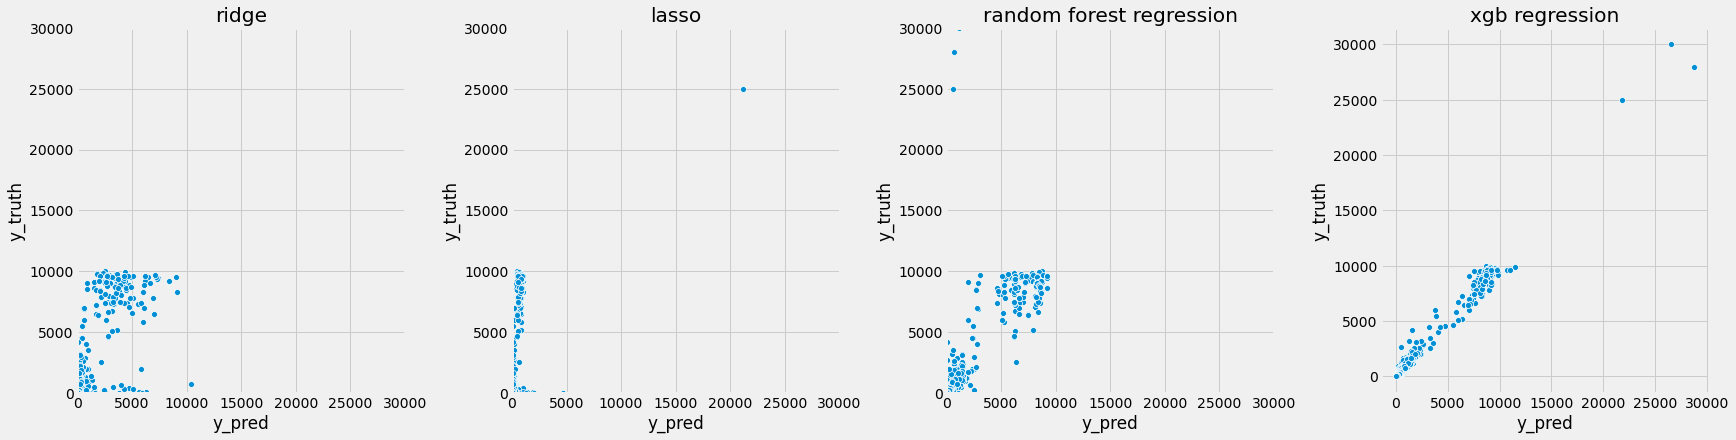

In [466]:
style.use('fivethirtyeight')

fig = plt.figure(constrained_layout=True, figsize=(24,6))
grid = gridspec.GridSpec(ncols=4, nrows=1, figure=fig)

## ridge
ax0 = fig.add_subplot(grid[0, 0])
## Set the title. 
ax0.set_title('ridge')
y_pred = np.exp(pipeline_ridge_ms.predict(original_df_train_all))
y_true = original_df_train_all['TARGET(PRICE_IN_LACS)']
ax0.set_xlim(xmin = 0, xmax = 30000)
ax0.set_ylim(ymin = 0, ymax = 30000)
sns.scatterplot(x = y_pred, y = y_true , ax=ax0)
plt.xlabel('y_pred')
plt.ylabel('y_truth')

## lasso
ax1 = fig.add_subplot(grid[0, 1])
## Set the title. 
ax1.set_title('lasso')
y_pred = np.exp(pipeline_lasso_ms.predict(original_df_train_all))
y_true = original_df_train_all['TARGET(PRICE_IN_LACS)']
ax1.set_xlim(xmin = 0, xmax = 30000)
ax1.set_ylim(ymin = 0, ymax = 30000)
sns.scatterplot(x = y_pred, y = y_true , ax=ax1)
plt.xlabel('y_pred')
plt.ylabel('y_truth')


## random forest regression
ax2 = fig.add_subplot(grid[0, 2])
## Set the title. 
ax2.set_title('random forest regression')
y_pred = np.exp(pipeline_rf_ms.predict(original_df_train_all))
y_true = original_df_train_all['TARGET(PRICE_IN_LACS)']
ax2.set_xlim(xmin = 0, xmax = 30000)
ax2.set_ylim(ymin = 0, ymax = 30000)
sns.scatterplot(x = y_pred, y = y_true , ax=ax2)
plt.xlabel('y_pred')
plt.ylabel('y_truth')


## xgb regression
ax3 = fig.add_subplot(grid[0, 3])
## Set the title. 
ax3.set_title('xgb regression')
y_pred = np.exp(pipeline_xgb_ms.predict(original_df_train_all))
y_true = original_df_train_all['TARGET(PRICE_IN_LACS)']
sns.scatterplot(x = y_pred, y = y_true , ax=ax3)
plt.xlabel('y_pred')
plt.ylabel('y_truth')

## Final Pipeline Construction and Training

In this section
- A xgb pipeline would be constructed using the selected hyperparameter in [Model Selection](##Model-Selection)
- The pipeline is be trained on complete train.csv dataset. (The model trained in cross validation consumed 4/5 of the traing data)
- <b>Note</b>: the prediction value is <b>log</b> house price. Apply <b>exp(pred)</b> to obtain house price predictions

### Training

In [361]:
params_xgb_final = {'n_estimators': 550, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'seed': 0,'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 1, 'random_state': 1, 'objective':'reg:squarederror'}
xgb = XGBRegressor(**params_xgb_final)
pipeline_xgb = Pipeline(steps = [('preprocess', preprocessingPipeline), ('xgb', xgb)])
pipeline_xgb.fit(original_df_train_all, Y_train_all)

Pipeline(steps=[('preprocess',
                 FeatureUnion(transformer_list=[('skewed_num_subline',
                                                 Pipeline(steps=[('selector',
                                                                  DataFrameSelector(attribute_names=['SQUARE_FT'])),
                                                                 ('log',
                                                                  FunctionTransformer(func=<ufunc 'log'>)),
                                                                 ('std',
                                                                  StandardScaler())])),
                                                ('other_num_subline',
                                                 Pipeline(steps=[('selector',
                                                                  DataFrameSelector(attribute_names=['BHK_NO.',
                                                                                                     

In [365]:
joblib.dump(pipeline_xgb, './ckpt/final_pipeline/pipeline_xgb_fnl.pkl')

['./ckpt/final_pipeline/pipeline_xgb_fnl.pkl']

<b>Training Performance</b>

In [381]:
# Training Metrics
y_true = original_df_train_all['TARGET(PRICE_IN_LACS)']
y_pred = np.exp(pipeline_xgb.predict(original_df_train_all))
print('The training mean_absolute_error is {:.3f}.'.format(mean_absolute_error(y_true, y_pred)))
print('The training r2_score is {:.3f}.'.format(r2_score(y_true, y_pred)))

The training mean_absolute_error is 16.588.
The training r2_score is 0.988.


<b>Feature Importance</b>

In [476]:
importance = pipeline_xgb['xgb'].feature_importances_
pd.DataFrame([importance], columns = column_names_encoded)

,SQUARE_FT,BHK_NO.,LONGITUDE,LATITUDE,UNDER_CONSTRUCTION,RERA,RESALE,POSTED_BY_dealer,POSTED_BY_owner,BHK_OR_RK_rk,ADDRESS_tier2,ADDRESS_tier3
0,0.109701,0.130965,0.039202,0.05247,0.009344,0.010694,0.067343,0.218165,0.072114,0.007161,0.234439,0.048403


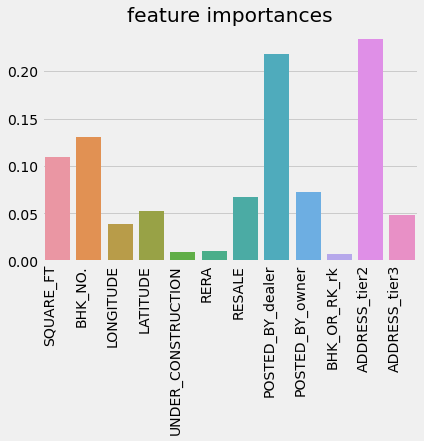

In [483]:
fig = sns.barplot(column_names_encoded, importance)
fig.set_title('feature importances')
fig.set_xticklabels(fig.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right')
plt.show()

Observations:
- Important features include SQUARE_FT, BHK_NO., POSTED_BY, city_tier
- This observation is consistant with the analysis in Section [Feature Interaction Analysis](#Interaction)

### Predict on Test.csv

In [385]:
pred_test = np.exp(pipeline_xgb.predict(df_test_all))


In [407]:
np.savetxt("./output/submission.csv", pred_test, delimiter=",")

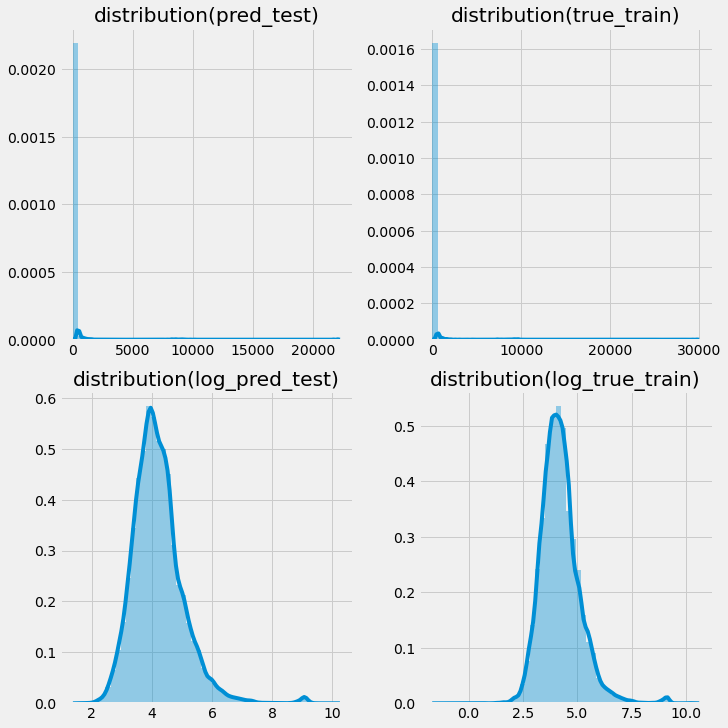

In [408]:
# Assess the test prediction against train true house prices
true_train = original_df_train_all['TARGET(PRICE_IN_LACS)'].to_numpy()

style.use('fivethirtyeight')
fig = plt.figure(constrained_layout=True, figsize=(10,10))
grid = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

## distribution
ax1 = fig.add_subplot(grid[0, 0])
## Set the title. 
ax1.set_title('distribution(pred_test)')
sns.distplot(pred_test, ax = ax1)

ax2 = fig.add_subplot(grid[0, 1])
## Set the title. 
ax2.set_title('distribution(true_train)')
sns.distplot(true_train, ax = ax2)

## log distribution
ax3 = fig.add_subplot(grid[1, 0])
## Set the title. 
ax3.set_title('distribution(log_pred_test)')
sns.distplot(np.log(pred_test), ax = ax3)

ax4 = fig.add_subplot(grid[1, 1])
## Set the title. 
ax4.set_title('distribution(log_true_train)')
sns.distplot(np.log(true_train), ax = ax4)

Obervation:
- The distribution of the predicted testing house prices look similar to that of truth house prices in training data
- If the distribution are consistent between train.csv and test.csv, the consistent distribution above is a good signal. The model looks making sense

# Summary

In this document, I performed:
- Explore Data Analysis
    - Feature Assessment
    - Feature - Target Interaction Analysis
    - Collinearity, Outlier Assessment
- Model Building
    - Preprocessing Pipeline Construction
    - Model and Hyperparameter Selection
    - Selected Model Pipeline Training
    - Pipeline Prediction on Test.csv Data

Major Practices and Considerations include:
- Feature Engineering:
    - Constructed 'city_tier' feature from 'ADDRESS' feature in order to harness the high cardinality of the 'ADDRESS' feature.
    - Log-transformed 'SQUARE_FT' and 'TARGET(PRICE_IN_LACS)' in order to cure the high skewness. Otherwise, the high skewness might set up improper relation ship between feature and target. And it could lead to negative predicted house price in the end.
- Model Selection:
    - As expected a Tree-based model (XGB Regressor) was employed
    - GridSearch has been used for hyperparameter optimization. If time or resources permit, RandomizedSearch may achieve better results
- Model Framework:
    - This is a structure modeling problem upon small dataset. Sklearn is good for this purpose.
    - H2O AutoML or DataRobot provide quick model selection api. But Sklearn framework was employed to demonstrate the comprehensive modeling process.
    - Deeplearning model in Tensorflow/Pytorch could also be used. But they are too heavy for this type of questions. However, for some computer vision / NLP / Graph based modeling exploration, they could be the optimal choice. Those kind of work usually took longer iteration.
    